In [63]:
import pandas as pd
import polars as pl
import seaborn as sns
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from tqdm import tqdm

In [64]:
train = pl.DataFrame(pd.concat([pd.read_csv("train.csv"), pd.read_csv("cirrhosis.csv")], axis=0).drop(columns=["ID", "id"]))
test = pl.read_csv("test.csv")

In [65]:
train = train.with_columns(
    pl.col("Stage").cast(pl.String)
)
test = test.with_columns(
    pl.col("Stage").cast(pl.String)
)

# EDA

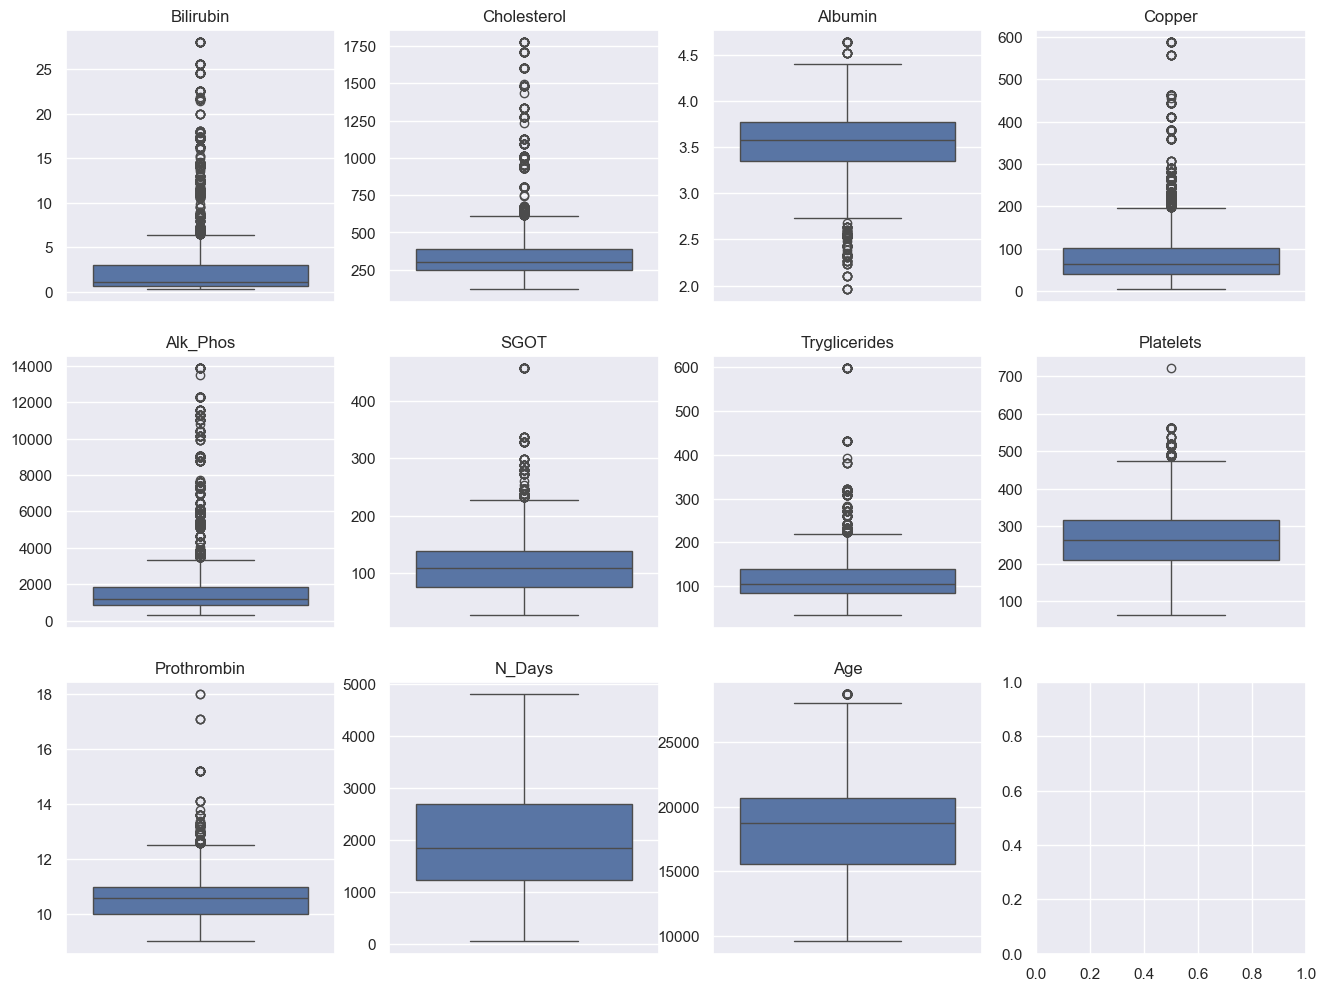

In [9]:
sns.set_theme(rc={'figure.figsize':(16,12)})
numeric_column_df = train.select(pl.col(pl.Float64), pl.col(pl.Int64)).drop("id")
n_rows = math.floor(math.sqrt(numeric_column_df.shape[1]))
n_cols = math.ceil(math.sqrt(numeric_column_df.shape[1]))
# Create the subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols)
for i, column in enumerate(numeric_column_df.columns):
    sns.boxplot(numeric_column_df[column], ax=axes[i // n_cols, i % n_cols]).set_title(column)

There are definitely a few columns that are candidates for having outliers that we might have to find a strategy to deal with

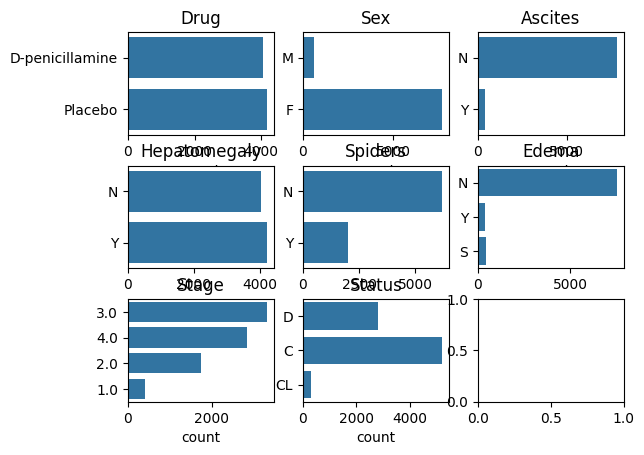

In [66]:
string_columns = train.select(pl.col(pl.String))
n_rows = math.floor(math.sqrt(string_columns.shape[1])) + 1
n_cols = math.ceil(math.sqrt(string_columns.shape[1]))
# Create the subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols)
for i, column in enumerate(string_columns.columns):
    sns.countplot(string_columns[column], ax=axes[i // n_cols, i % n_cols]).set_title(column)

plt.subplots_adjust(hspace=0.3)

In [67]:
train

N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
i64,str,i64,str,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
999,"""D-penicillamine""",21532,"""M""","""N""","""N""","""N""","""N""",2.3,316.0,3.35,172.0,1601.0,179.8,63.0,394.0,9.7,"""3.0""","""D"""
2574,"""Placebo""",19237,"""F""","""N""","""N""","""N""","""N""",0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,"""3.0""","""C"""
3428,"""Placebo""",13727,"""F""","""N""","""Y""","""Y""","""Y""",3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,"""4.0""","""D"""
2576,"""Placebo""",18460,"""F""","""N""","""N""","""N""","""N""",0.6,256.0,3.5,58.0,1653.0,71.3,96.0,269.0,10.7,"""3.0""","""C"""
788,"""Placebo""",16658,"""F""","""N""","""Y""","""N""","""N""",1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,"""4.0""","""C"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
681,null,24472,"""F""",null,null,null,"""N""",1.2,null,2.96,null,null,null,null,174.0,10.9,"""3.0""","""D"""
1103,null,14245,"""F""",null,null,null,"""N""",0.9,null,3.83,null,null,null,null,180.0,11.2,"""4.0""","""C"""
1055,null,20819,"""F""",null,null,null,"""N""",1.6,null,3.42,null,null,null,null,143.0,9.9,"""3.0""","""C"""


quite a lot of unbalanced classes, might be useful to see whether synthetic data helps with this

In [11]:
# quick check to see whether we have some illogical values or how many nulls we are dealing with
# quite a lot of nulls, so we might need a strategy here
train.describe()

statistic,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
str,f64,f64,str,f64,str,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""count""",7905.0,8323.0,"""8217""",8323.0,"""8323""","""8217""","""8217""","""8217""","""8323""",8323.0,8189.0,8323.0,8215.0,8217.0,8217.0,8187.0,8312.0,8321.0,"""8317""","""8323"""
"""null_count""",418.0,0.0,"""106""",0.0,"""0""","""106""","""106""","""106""","""0""",0.0,134.0,0.0,108.0,106.0,106.0,136.0,11.0,2.0,"""6""","""0"""
"""mean""",3952.0,2024.528776,null,18381.192359,null,null,null,null,null,2.62594,351.219074,3.545767,84.421546,1823.044883,114.90653,115.662636,264.827238,10.634575,null,null
"""std""",2282.121272,1094.968696,null,3686.832308,null,null,null,null,null,3.847146,196.775246,0.350697,76.32748,1913.388685,49.134067,53.03766,88.039809,0.795707,null,null
"""min""",0.0,41.0,"""D-penicillamine""",9598.0,"""F""","""N""","""N""","""N""","""N""",0.3,120.0,1.96,4.0,289.0,26.35,33.0,62.0,9.0,"""1""","""C"""
"""25%""",1976.0,1223.0,null,15574.0,null,null,null,null,null,0.7,248.0,3.35,39.0,834.0,75.95,84.0,210.0,10.0,null,null
"""50%""",3952.0,1831.0,null,18713.0,null,null,null,null,null,1.1,299.0,3.58,63.0,1181.0,108.5,104.0,264.0,10.6,null,null
"""75%""",5928.0,2689.0,null,20684.0,null,null,null,null,null,3.0,392.0,3.77,102.0,1857.0,137.95,139.0,316.0,11.0,null,null
"""max""",7904.0,4795.0,"""Placebo""",28650.0,"""M""","""Y""","""Y""","""Y""","""Y""",28.0,1775.0,4.64,588.0,13862.4,457.25,598.0,721.0,18.0,"""4""","""D"""


# Baseline Modelling
We'll start with some baseline models without much data wrangling just to establish a baseline we want to beat

In [8]:
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, HistGradientBoostingClassifier 
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeClassifier, RidgeClassifierCV
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [12]:
le = LabelEncoder()
random_state=235
X=train.drop("Status").to_dummies(["Drug", "Sex", "Ascities", "Hepatomegaly", "Spiders", "Edema", "Stage", "Ascites"]).to_pandas()
y=train["Status"].to_pandas()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.2, random_state=random_state)
y_train = le.fit_transform(y_train)
y_valid = le.fit_transform(y_valid)

In [6]:
# for now, we only use the base models that can deal with null values
base_models=[
    HistGradientBoostingClassifier(random_state=random_state),
    DecisionTreeClassifier(random_state=random_state),
    RandomForestClassifier(random_state=random_state),
    CatBoostClassifier(random_state=random_state, silent=True),
    LGBMClassifier(random_state=random_state, verbose=0),
    XGBClassifier(random_state=random_state, objective='multi:softmax')
]
trained_base_models = [model.fit(X_train, y_train) for model in tqdm(base_models)]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:07<00:00,  1.30s/it]


In [7]:
predicted_probabilities = [model.predict_proba(X_valid) for model in trained_base_models]
log_loss_validation = [log_loss(y_valid, probabilities) for probabilities in predicted_probabilities]
print(f"""
Log-loss for HistGradientBoostingClassifier: {log_loss_validation[0]:.2}
Log-loss for DecisionTreeClassifier: {log_loss_validation[1]:.2}
Log-loss for RandomForestClassifier: {log_loss_validation[2]:.2}
Log-loss for CatBoostClassifier: {log_loss_validation[3]:.2}
Log-loss for LGBMClassifier: {log_loss_validation[4]:.2}
Log-loss for XGBClassifier: {log_loss_validation[5]:.2}
""")


Log-loss for HistGradientBoostingClassifier: 0.5
Log-loss for DecisionTreeClassifier: 9.1
Log-loss for RandomForestClassifier: 0.55
Log-loss for CatBoostClassifier: 0.47
Log-loss for LGBMClassifier: 0.47
Log-loss for XGBClassifier: 0.52



The decision tree classifier does not show the best performance. Therefore we will not be tuning it.

## Tuning the baseline models

In [8]:
from optuna_integration.xgboost import XGBoostPruningCallback
# first we'll define the objective functions that we will use for tuning
def objective_hist_gradient_boosting(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'max_iter': trial.suggest_int('max_iter', 50, 1000),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 2, 100),
        'max_depth': trial.suggest_int('max_depth', 2, 50),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 10, 100),
        'l2_regularization': trial.suggest_float('l2_regularization', 0, 1.0),
        'max_features': trial.suggest_float('max_features', 0, 1),
        'max_bins': trial.suggest_int('max_bins', 2, 255),
        'random_state': random_state
    }
    mod = HistGradientBoostingClassifier(**params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    cv = abs(cross_val_score(mod, X_train, y_train, cv=skf, scoring='neg_log_loss').mean())
    return cv

def objective_random_forest(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
        'max_depth': trial.suggest_int('max_depth', 1, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 50),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 50),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'random_state': random_state
    }
    mod = RandomForestClassifier(**params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    cv = abs(cross_val_score(mod, X_train, y_train, cv=skf, scoring='neg_log_loss').mean())
    return cv

def objective_cat_boost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 50, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 50),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 2, 50),
        'grow_policy': 'Lossguide',
        'random_state': random_state,
        'silent': True
    }
    mod = CatBoostClassifier(**params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    cv = abs(cross_val_score(mod, X_train, y_train, cv=skf, scoring='neg_log_loss').mean())
    return cv
    
def objective_lgbm(trial):
    params = {
        'n_estimators': trial.suggest_int('iterations', 50, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.5, 10),
        'subsample': trial.suggest_float('subsample', 0.01, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1),
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'random_state': random_state,
        'verbose': 0
    }
    mod = LGBMClassifier(**params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    cv = abs(cross_val_score(mod, X_train, y_train, cv=skf, scoring='neg_log_loss').mean())
    return cv

def objective_xgb(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False,
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'random_state': random_state,
        'objective': 'multi:softprob'
    }
    if params['booster'] == 'gbtree' or params['booster'] == 'dart':
        params['max_depth'] = trial.suggest_int('max_depth', 1, 9)
        params['eta'] = trial.suggest_loguniform('eta', 1e-8, 1.0)
        params['gamma'] = trial.suggest_loguniform('gamma', 1e-8, 1.0)
        params['grow_policy'] = trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide'])
    if params['booster'] == 'dart':
        params['sample_type'] = trial.suggest_categorical('sample_type', ['uniform', 'weighted'])
        params['normalize_type'] = trial.suggest_categorical('normalize_type', ['tree', 'forest'])
        params['rate_drop'] = trial.suggest_loguniform('rate_drop', 1e-8, 1.0)
        params['skip_drop'] = trial.suggest_loguniform('skip_drop', 1e-8, 1.0)
    mod = XGBClassifier(
        **params, 
        early_stopping_rounds=100,
        callbacks=[XGBoostPruningCallback(trial=trial, observation_key="validation_0-mlogloss")],
        verbosity=0
        )
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    cv_scores = []
    for train_idx, val_idx in skf.split(X_train.reset_index(), y_train):
        X_train_cv = X_train.iloc[train_idx]
        X_val_cv = X_train.iloc[val_idx]
        y_train_cv = y_train[train_idx]
        y_val_cv = y_train[val_idx]
        
        mod.fit(
            X_train_cv, y_train_cv,
            eval_set=[(X_val_cv, y_val_cv)],
            verbose=False
        )
        # Report intermediate objective value
        val_pred = mod.predict_proba(X_val_cv)
        logloss = log_loss(y_val_cv, val_pred)
        trial.report(logloss, step=len(cv_scores))
        
        # Prune if the trial is unpromising
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        cv_scores.append(logloss)
    return np.mean(cv_scores)

C:\Users\nicoh\OneDrive\Dokumente\kaggle\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# let's create the studies
import optuna
import json
from sklearn.model_selection import cross_val_score, StratifiedKFold
hist_gradient_boosting_study = optuna.create_study(direction="minimize", study_name="s_1")
random_forest_study = optuna.create_study(direction="minimize", study_name="s_2")
cat_boost_study = optuna.create_study(direction="minimize", study_name="s_3")
lgbm_study = optuna.create_study(direction="minimize", study_name="s_4")
xgb_study = optuna.create_study(direction="minimize", study_name="s_5")

[I 2024-08-16 17:29:38,315] A new study created in memory with name: s_1
[I 2024-08-16 17:29:38,316] A new study created in memory with name: s_2
[I 2024-08-16 17:29:38,316] A new study created in memory with name: s_3
[I 2024-08-16 17:29:38,317] A new study created in memory with name: s_4
[I 2024-08-16 17:29:38,318] A new study created in memory with name: s_5


In [ ]:
# optimizing and saving the best params
n_trials=50
n_jobs=4
hist_gradient_boosting_study.optimize(objective_hist_gradient_boosting, n_trials=n_trials, n_jobs=n_jobs)
with open("params_hist_gradient_boosting.json", "w") as f:
    json.dump(hist_gradient_boosting_study.best_params, f)
random_forest_study.optimize(objective_random_forest, n_trials=n_trials, n_jobs=n_jobs)
with open("params_random_forest.json", "w") as f:
    json.dump(random_forest_study.best_params, f)
cat_boost_study.optimize(objective_cat_boost, n_trials=n_trials, n_jobs=n_jobs)
with open("params_cat_boost.json", "w") as f:
    json.dump(cat_boost_study.best_params, f)
lgbm_study.optimize(objective_lgbm, n_trials=n_trials, n_jobs=n_jobs)
with open("params_lgbm.json", "w") as f:
    json.dump(lgbm_study.best_params, f)
xgb_study.optimize(objective_xgb, n_trials=n_trials, n_jobs=n_jobs)
with open("params_xgb.json", "w") as f:
    json.dump(xgb_study.best_params, f)

In [6]:
with open("params_hist_gradient_boosting.json", "r") as f:
    params_hist_gradient_boosting = json.load(f)

with open("params_random_forest.json", "r") as f:
    params_random_forest = json.load(f)

with open("params_cat_boost.json", "r") as f:
    params_cat_boost = json.load(f)

with open("params_lgbm.json", "r") as f:
    params_lgbm = json.load(f)

with open("params_xgb.json", "r") as f:
    params_xgb = json.load(f)

In [24]:
tuned_models = [
    HistGradientBoostingClassifier(**params_hist_gradient_boosting, random_state=random_state),
    RandomForestClassifier(**params_random_forest, random_state=random_state),
    CatBoostClassifier(**params_cat_boost, random_state=random_state, silent=True),
    LGBMClassifier(**params_lgbm, random_state=random_state, verbose=-1),
    XGBClassifier(**params_xgb, random_state=random_state)
]

In [25]:
trained_tuned_models = [model.fit(X_train, y_train) for model in tqdm(tuned_models)]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.73s/it]


In [26]:
predicted_probabilities_tuned_models = [model.predict_proba(X_valid) for model in trained_tuned_models]
log_loss_validation_tuned_models = [log_loss(y_valid, probabilities) for probabilities in predicted_probabilities_tuned_models]
print(f"""
Log-loss for HistGradientBoostingClassifier: {log_loss_validation_tuned_models[0]:.2}
Log-loss for RandomForestClassifier: {log_loss_validation_tuned_models[1]:.2}
Log-loss for CatBoostClassifier: {log_loss_validation_tuned_models[2]:.2}
Log-loss for LGBMClassifier: {log_loss_validation_tuned_models[3]:.2}
Log-loss for XGBClassifier: {log_loss_validation_tuned_models[4]:.2}
""")


Log-loss for HistGradientBoostingClassifier: 0.45
Log-loss for RandomForestClassifier: 0.47
Log-loss for CatBoostClassifier: 0.46
Log-loss for LGBMClassifier: 0.46
Log-loss for XGBClassifier: 0.44



In [27]:
from sklearn.ensemble import VotingClassifier
Ensemble = VotingClassifier(
    estimators = [
        ('hist_gradient_boosting', trained_tuned_models[0]),
        ('random_forest', trained_tuned_models[1]),
        ('cat_boost', trained_tuned_models[2]),
        ('lgbm', trained_tuned_models[3]),
        ('xgb', trained_tuned_models[4])
    ],
    voting='soft'
)
Ensemble.fit(X_train, y_train)

VotingClassifier(estimators=[('hist_gradient_boosting',
                              HistGradientBoostingClassifier(l2_regularization=0.9959340210430196,
                                                             learning_rate=0.3345617106757586,
                                                             max_bins=253,
                                                             max_depth=21,
                                                             max_features=0.4324133444871417,
                                                             max_iter=644,
                                                             max_leaf_nodes=2,
                                                             min_samples_leaf=42,
                                                             random_state=235)),
                             ('random_forest',
                              RandomForestClassifier(criterion='log_loss',
                                                     max_de...
                                            grow_policy='depthwise',
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.021882864176616147,
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=5,
                                            max_leaves=None, min_child_weight=9,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=920, n_jobs=None,
                                            num_parallel_tree=None, ...))],
                 voting='soft')

In [28]:
print(f"""
Log-loss for Ensemble Classifier: {log_loss(y_valid, Ensemble.predict_proba(X_valid)):.2}
""")


Log-loss for Ensemble Classifier: 0.44



In [42]:
X_test = test.with_columns([
    pl.lit(0).alias('Ascites_null'),
    pl.lit(0).alias('Drug_null'),
    pl.lit(0).alias('Hepatomegaly_null'),
    pl.lit(0).alias('Spiders_null'),
    pl.lit(0).alias('Stage_null')
]).to_dummies(["Drug", "Sex", "Ascities", "Hepatomegaly", "Spiders", "Edema", "Stage", "Ascites"]).to_pandas().drop(columns="id")

In [57]:
X_test = X_test[X_train.columns]
probs_hist_gradient_boosting = pd.DataFrame(trained_tuned_models[0].predict_proba(X_test))
probs_random_forest = pd.DataFrame(trained_tuned_models[1].predict_proba(X_test))
probs_cat_boost = pd.DataFrame(trained_tuned_models[2].predict_proba(X_test))
probs_lgbm = pd.DataFrame(trained_tuned_models[3].predict_proba(X_test))
probs_xgb = pd.DataFrame(trained_tuned_models[4].predict_proba(X_test))
probs_ensemble = pd.DataFrame(Ensemble.predict_proba(X_test))


In [58]:
probs_hist_gradient_boosting.columns = ['Status_' + c for c in le.classes_]
probs_random_forest.columns = ['Status_' + c for c in le.classes_]
probs_cat_boost.columns = ['Status_' + c for c in le.classes_]
probs_lgbm.columns = ['Status_' + c for c in le.classes_]
probs_xgb.columns = ['Status_' + c for c in le.classes_]
probs_ensemble.columns = ['Status_' + c for c in le.classes_]

In [59]:
probs_hist_gradient_boosting = pd.concat([test[['id']].to_pandas(), probs_hist_gradient_boosting], axis=1)
probs_random_forest = pd.concat([test[['id']].to_pandas(), probs_random_forest], axis=1)
probs_cat_boost = pd.concat([test[['id']].to_pandas(), probs_cat_boost], axis=1)
probs_lgbm = pd.concat([test[['id']].to_pandas(), probs_lgbm], axis=1)
probs_xgb = pd.concat([test[['id']].to_pandas(), probs_xgb], axis=1)
probs_ensemble = pd.concat([test[['id']].to_pandas(), probs_ensemble], axis=1)

In [62]:
probs_hist_gradient_boosting.to_csv("predictions_hist_gradient_boosting.csv",index=False)
probs_random_forest.to_csv("predictions_random_forest.csv",index=False)
probs_cat_boost.to_csv("predictions_cat_boost.csv",index=False)
probs_lgbm.to_csv("predictions_lgbm.csv",index=False)
probs_xgb.to_csv("predictions_xgb.csv",index=False)
probs_ensemble.to_csv("predictions_ensemble.csv",index=False)

In [61]:
probs_hist_gradient_boosting.to_csv("predictions_hist_gradient_boosting.csv",index=False)

,id,Status_C,Status_CL,Status_D
0,7905,0.390601,0.010258,0.599141
1,7906,0.393942,0.427961,0.178097
2,7907,0.009864,0.000136,0.990000
3,7908,0.960639,0.004893,0.034468
4,7909,0.867961,0.031835,0.100204
...,...,...,...,...
5266,13171,0.951969,0.006657,0.041374
5267,13172,0.980169,0.003508,0.016323
5268,13173,0.872732,0.006159,0.121109
5269,13174,0.991087,0.003983,0.004929


## Imputing the data

In [12]:
from sklearn.impute import KNNImputer
imputer = KNNImputer()
X_train_imp, X_valid_imp, y_train_imp, y_valid_imp = train_test_split(X, y, test_size=.2, random_state=random_state)
y_train_imp = le.fit_transform(y_train_imp)
y_valid_imp = le.fit_transform(y_valid_imp)
X_train_imp = imputer.fit_transform(X_train_imp)
X_valid_imp = imputer.fit_transform(X_valid_imp)

In [ ]:
base_models_imp=[
    BernoulliNB(), GaussianNB(), ExtraTreeClassifier(random_state=random_state),
    ExtraTreesClassifier(random_state=random_state), KNeighborsClassifier(),
    LinearDiscriminantAnalysis(), 
    HistGradientBoostingClassifier(random_state=random_state), QuadraticDiscriminantAnalysis(),
    LogisticRegression(multi_class='multinomial'),
    LogisticRegressionCV(multi_class="multinomial"),
    DecisionTreeClassifier(random_state=random_state),
    RandomForestClassifier(random_state=random_state),
    CatBoostClassifier(random_state=random_state, silent=True),
    LGBMClassifier(random_state=random_state, verbose=0),
    XGBClassifier(random_state=random_state, objective='multi:softmax')
]
trained_base_models_imp = [model.fit(X_train_imp, y_train_imp) for model in tqdm(base_models_imp)]

In [43]:
predicted_probabilities_imp = [model.predict_proba(X_valid_imp) for model in trained_base_models_imp]
log_loss_validation_imp = [log_loss(y_valid_imp, probabilities) for probabilities in predicted_probabilities_imp]
print(f"""
Log-loss for BernoulliNB: {log_loss_validation_imp[0]:.2}
Log-loss for GaussianNB: {log_loss_validation_imp[1]:.2}
Log-loss for ExtraTreeClassifier: {log_loss_validation_imp[2]:.2}
Log-loss for ExtraTreesClassifier: {log_loss_validation_imp[3]:.2}
Log-loss for KNeighborsClassifier: {log_loss_validation_imp[4]:.2}
Log-loss for LinearDiscriminantAnalysis: {log_loss_validation_imp[5]:.2}
Log-loss for HistGradientBoostingClassifier: {log_loss_validation_imp[6]:.2}
Log-loss for QuadraticDiscriminantAnalysis: {log_loss_validation_imp[7]:.2}
Log-loss for LogisticRegression: {log_loss_validation_imp[8]:.2}
Log-loss for LogisticRegressionCV: {log_loss_validation_imp[9]:.2}
Log-loss for DecisionTreeClassifier: {log_loss_validation_imp[10]:.2}
Log-loss for RandomForestClassifier: {log_loss_validation_imp[11]:.2}
Log-loss for CatBoostClassifier: {log_loss_validation_imp[12]:.2}
Log-loss for LGBMClassifier: {log_loss_validation_imp[13]:.2}
Log-loss for XGBClassifier: {log_loss_validation_imp[14]:.2}
""")


Log-loss for BernoulliNB: 0.91
Log-loss for GaussianNB: 2.2
Log-loss for ExtraTreeClassifier: 1.1e+01
Log-loss for ExtraTreesClassifier: 0.6
Log-loss for KNeighborsClassifier: 3.4
Log-loss for LinearDiscriminantAnalysis: 0.55
Log-loss for HistGradientBoostingClassifier: 0.5
Log-loss for QuadraticDiscriminantAnalysis: 3.2e+01
Log-loss for LogisticRegression: 0.65
Log-loss for LogisticRegressionCV: 0.64
Log-loss for DecisionTreeClassifier: 9.1
Log-loss for RandomForestClassifier: 0.6
Log-loss for CatBoostClassifier: 0.47
Log-loss for LGBMClassifier: 0.47
Log-loss for XGBClassifier: 0.51



Catboost and LGBM still have the same error then the baseline models of the non-imputed data, XGB only improved by 0.01. RandomForest got worse

## Outlier Detection

In [52]:
from sklearn.neighbors import LocalOutlierFactor
cols=["Bilirubin", "Cholesterol", "Albumin", "Copper", "Alk_Phos", "SGOT", "Tryglicerides", "Platelets", "Prothrombin"]

## Replacing with the nearest value

In [75]:
X_outlier = X
for col in tqdm(cols):
    col = cols[0]
    fit = LocalOutlierFactor(n_neighbors=20, contamination=0.1).fit_predict(X_outlier[[col]].dropna())
    temp_df=pd.concat([X[[col]], pd.Series(fit)], axis=1)
    min_value = temp_df[temp_df[0] != -1][col].min()
    max_value = temp_df[temp_df[0] != -1][col].max()
    X_outlier.loc[X_outlier[col] < min_value, col] = min_value
    X_outlier.loc[X_outlier[col] > max_value, col] = max_value

X_train_outlier_1, X_valid_outlier_1, y_train_outlier_1, y_valid_outlier_1 = train_test_split(X_outlier, y, test_size=.2, random_state=random_state)
y_train_outlier_1 = le.fit_transform(y_train_outlier_1)
y_valid_outlier_1 = le.fit_transform(y_valid_outlier_1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 20.46it/s]


In [77]:
# for now, we only use the base models that can deal with null values
base_models_outlier_1=[
    HistGradientBoostingClassifier(random_state=random_state),
    DecisionTreeClassifier(random_state=random_state),
    RandomForestClassifier(random_state=random_state),
    CatBoostClassifier(random_state=random_state, silent=True),
    LGBMClassifier(random_state=random_state, verbose=0),
    XGBClassifier(random_state=random_state, objective='multi:softmax')
]
trained_base_models_outlier_1 = [model.fit(X_train_outlier_1, y_train_outlier_1) for model in tqdm(base_models_outlier_1)]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:07<00:00,  1.24s/it]


In [78]:
predicted_probabilities_outlier_1 = [model.predict_proba(X_valid_outlier_1) for model in trained_base_models_outlier_1]
log_loss_validation_outlier_1 = [log_loss(y_valid_outlier_1, probabilities) for probabilities in predicted_probabilities_outlier_1]
print(f"""
Log-loss for HistGradientBoostingClassifier: {log_loss_validation_outlier_1[0]:.2}
Log-loss for DecisionTreeClassifier: {log_loss_validation_outlier_1[1]:.2}
Log-loss for RandomForestClassifier: {log_loss_validation_outlier_1[2]:.2}
Log-loss for CatBoostClassifier: {log_loss_validation_outlier_1[3]:.2}
Log-loss for LGBMClassifier: {log_loss_validation_outlier_1[4]:.2}
Log-loss for XGBClassifier: {log_loss_validation_outlier_1[5]:.2}
""")


Log-loss for HistGradientBoostingClassifier: 0.5
Log-loss for DecisionTreeClassifier: 9.1
Log-loss for RandomForestClassifier: 0.55
Log-loss for CatBoostClassifier: 0.47
Log-loss for LGBMClassifier: 0.47
Log-loss for XGBClassifier: 0.52



## Setting outliers to None

In [79]:
X_outlier = X
for col in tqdm(cols):
    col = cols[0]
    fit = LocalOutlierFactor(n_neighbors=20, contamination=0.1).fit_predict(X_outlier[[col]].dropna())
    temp_df=pd.concat([X[[col]], pd.Series(fit)], axis=1)
    min_value = temp_df[temp_df[0] != -1][col].min()
    max_value = temp_df[temp_df[0] != -1][col].max()
    X_outlier.loc[X_outlier[col] < min_value, col] = pd.NA
    X_outlier.loc[X_outlier[col] > max_value, col] = pd.NA

X_train_outlier_2, X_valid_outlier_2, y_train_outlier_2, y_valid_outlier_2 = train_test_split(X_outlier, y, test_size=.2, random_state=random_state)
y_train_outlier_2 = le.fit_transform(y_train_outlier_2)
y_valid_outlier_2 = le.fit_transform(y_valid_outlier_2)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 22.73it/s]


In [80]:
# for now, we only use the base models that can deal with null values
base_models_outlier_2=[
    HistGradientBoostingClassifier(random_state=random_state),
    DecisionTreeClassifier(random_state=random_state),
    RandomForestClassifier(random_state=random_state),
    CatBoostClassifier(random_state=random_state, silent=True),
    LGBMClassifier(random_state=random_state, verbose=0),
    XGBClassifier(random_state=random_state, objective='multi:softmax')
]
trained_base_models_outlier_2 = [model.fit(X_train_outlier_2, y_train_outlier_2) for model in tqdm(base_models_outlier_2)]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:07<00:00,  1.31s/it]


In [81]:
predicted_probabilities_outlier_2 = [model.predict_proba(X_valid_outlier_2) for model in trained_base_models_outlier_2]
log_loss_validation_outlier_2 = [log_loss(y_valid_outlier_2, probabilities) for probabilities in predicted_probabilities_outlier_2]
print(f"""
Log-loss for HistGradientBoostingClassifier: {log_loss_validation_outlier_2[0]:.2}
Log-loss for DecisionTreeClassifier: {log_loss_validation_outlier_2[1]:.2}
Log-loss for RandomForestClassifier: {log_loss_validation_outlier_2[2]:.2}
Log-loss for CatBoostClassifier: {log_loss_validation_outlier_2[3]:.2}
Log-loss for LGBMClassifier: {log_loss_validation_outlier_2[4]:.2}
Log-loss for XGBClassifier: {log_loss_validation_outlier_2[5]:.2}
""")


Log-loss for HistGradientBoostingClassifier: 0.5
Log-loss for DecisionTreeClassifier: 9.1
Log-loss for RandomForestClassifier: 0.55
Log-loss for CatBoostClassifier: 0.47
Log-loss for LGBMClassifier: 0.47
Log-loss for XGBClassifier: 0.52



Neither of these methods showed great improvement, which is why I decided against exploring it further